In [41]:
from pathlib import Path
import pickle
from time import time
from typing import List, Dict, Set, Tuple
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.datasets import load_iris
import numpy as np
import gensim
import networkx as nx
from node2vec import Node2Vec
from sklearn.decomposition import PCA
from ge.classify import read_node_label, Classifier
from ge import LINE
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import tensorflow as tf


In [42]:
class GraphLoader:
    def __init__(self):
        self.graph = None
        self.title = None
        
    def build_graph(self, 
                    dataframe: pd.DataFrame, 
                    columns: List, 
                    edge_list: List,
                    verbose: bool = True,
                    title: str = 'Unnamed'):
        self.title = title
        t0 = time()
        self.graph = nx.Graph(name = self.title)

        # Add Nodes to the graph.
        for column in columns:
            self.graph.add_nodes_from(dataframe[column].values, label=column)

        # Add remaining columns as Node attributes. Optional
        remaining = dataframe.columns.difference(columns)
        for node, data in self.graph.nodes(data=True):
            if data["label"] == "K":
                self.graph.nodes[node]["K"] = dataframe.loc[dataframe["K"] == int(node), remaining].squeeze().to_dict()

        # Add Edges.
        for _, row in dataframe.loc[:, columns].iterrows():
            for edge in edge_list:
                self.graph.add_edge(row[edge[0]], row[edge[1]])
        
        if verbose:
            print(f"FINISHED in {np.round(time() - t0, 3)} seconds.")
            print(nx.info(self.graph))
        
        return self.graph

    def draw_graph(self, graph: nx.Graph, node_colors: dict, node: str = None, radius: int = 1) -> None:
        def assign_colors(graph: nx.Graph) -> List:
            # Assign Colors to nodes
            colors = []
            for n, data in graph.nodes(data=True):
                node = data["label"]
                colors.append(node_colors.get(node, "white"))
            return colors

        f = plt.figure(figsize = (20,12), facecolor="darkgray")
        ax = f.add_subplot()

        if not node:    
            plt.title(self.title)
        else:
            plt.title(f"Ego Graph around the node {node}, (radius={radius})")
            graph = nx.ego_graph(graph, node, radius = radius)
        
        colors = assign_colors(graph)
        nx.draw_networkx(graph, node_size = 300, node_color = colors, with_labels = False)
        # Add an empty plot to set custom legends
        from matplotlib.lines import Line2D
        ax.scatter([],[])
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='K', markerfacecolor = node_colors['K'], markersize=15),
            Line2D([0], [0], marker='o', color='w', label='S1', markerfacecolor = node_colors['S1'], markersize=10),
            Line2D([0], [0], marker='o', color='w', label='S2', markerfacecolor = node_colors['S2'], markersize=10),
            Line2D([0], [0], marker='o', color='w', label='S3', markerfacecolor = node_colors['S3'], markersize=10),
            Line2D([0], [0], marker='o', color='w', label='S4', markerfacecolor = node_colors['S4'], markersize=10),
            Line2D([0], [0], marker='o', color='w', label='S5', markerfacecolor = node_colors['S5'], markersize=10),
            Line2D([0], [0], marker='o', color='w', label='S6', markerfacecolor = node_colors['S6'], markersize=10),

        ]
        ax.legend(handles=legend_elements, loc='best')
        plt.show()

In [43]:
attrition_data = 'cbd.csv'
df_attrition = pd.read_csv(attrition_data)
target_column = 'word'
selected_columns = ['K', 'S1', 'S2', 'S3', \
                    'S4', 'S5','S6']

df_attrition = df_attrition.loc[:, selected_columns]

In [44]:
nodes = selected_columns[:] # Do not select Attrition as a feature node
edges = [("K","S1"),
         ("K","S2"),
         ("K","S3"),
         ("K","S4"),
         ("K","S5"),
         ("K","S6")]

node_colors = { # freestyle, update any color.
    "K": "dodgerblue", 
    "S1":"lightgreen", 
    "S2":"tan", 
    "S3":"salmon",
    "S4":"darkcyan",
    "S5":"lightblue",
    "S6":"yellow"
}

FINISHED in 0.096 seconds.
Graph named 'Multilingual Out of Vocabulary Terms relationship' with 502 nodes and 693 edges


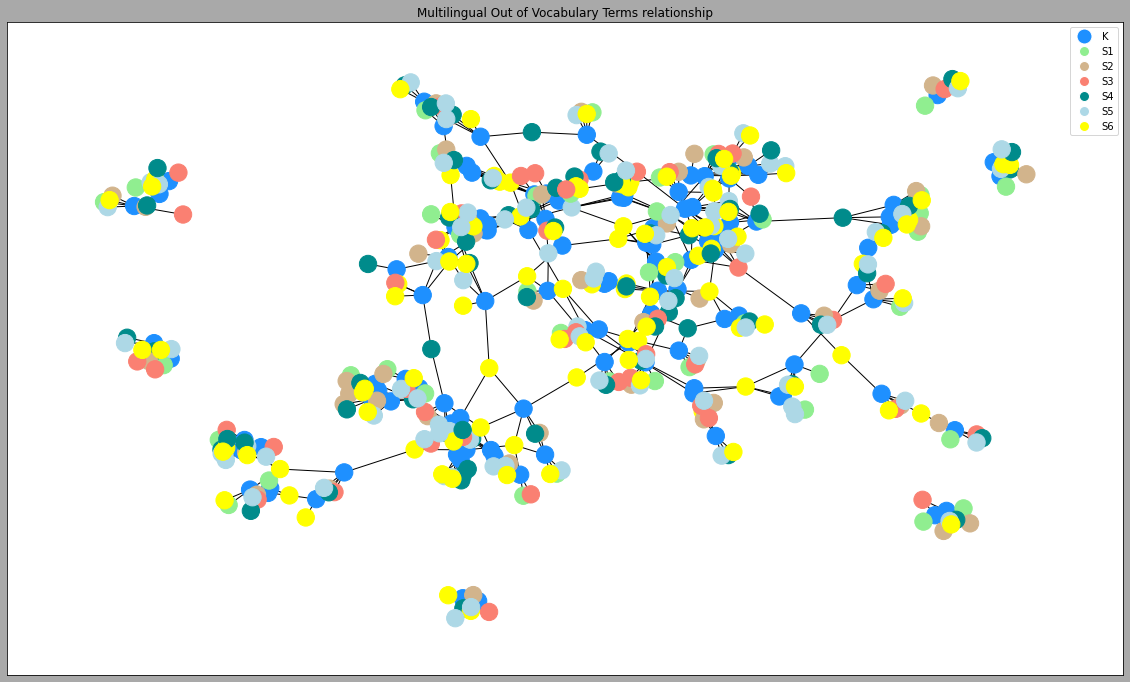

In [45]:
graph_loader = GraphLoader()
demo_graph = graph_loader.build_graph(
            dataframe = df_attrition.loc[:, selected_columns[:]],
            columns = nodes, 
            edge_list = edges,
            verbose = True,
            title = 'Multilingual Out of Vocabulary Terms relationship'
        )
# graph_loader.draw_graph(demo_graph, node_colors, node = 5, radius = 2) # show only the nodes that are at a distance of 2 edges from the employee 5.
graph_loader.draw_graph(demo_graph, node_colors) # Show the whole graph

## Line


In [66]:
CWD = Path().cwd()
EMBEDDINGS_DIR = CWD / 'embeddings'
EMBEDDINGS_DIR.mkdir(parents=True, exist_ok=True)
SEED = 12
History=0
class Line_VectorizerConfig:
    dimensions = 128
    walk_length = 30
    num_walks = 50
    window = 10
    min_count = 1
    batch_words = 100

class Line_NodeEmbedding:

    def __init__(self) -> None:
        self.vectorizer = None
        self.model = None
        
    def generate_random_walks(self, graph: nx.Graph, **params) -> None:
        self.vectorizer = LINE(graph, **params)
        # return self.vectorizer

    def fit(self, **params) -> tf.keras.models:
        if self.vectorizer is None:
            raise Exception("No random walks. Generate Random walks by calling generate_random_walks() method first.")
        self.model = self.vectorizer.train(**params)
        return self.model
    def save_model(self, model: tf.keras.models, save_to: Path = EMBEDDINGS_DIR, prefix: str = None) -> None:
        d = Line_VectorizerConfig.dimensions
        w = Line_VectorizerConfig.walk_length
        n = Line_VectorizerConfig.num_walks
        embeddings_filename = f"{prefix}_LINE_embeddings_{d}_{w}_{n}.txt"
        model_filename = f"{prefix}_LINE_model_{d}_{w}_{n}.pkl"
        # Save only the embeddings in a txt file.
        # Save the entire model.
        self.model.save(str(EMBEDDINGS_DIR/model_filename))
        print(f"Model and embeddings saved to: {str(EMBEDDINGS_DIR/model_filename)}")
    def load_model(self, model_filename: str = None, load_from: Path = EMBEDDINGS_DIR) -> tf.keras.models:
        if Path(EMBEDDINGS_DIR / model_filename).exists():
            print("Loaded Model: ", model_filename)
            with Path(EMBEDDINGS_DIR / model_filename).open(mode="r+b") as file:
                self.model = pickle.load(file)
        else:
            raise FileNotFoundError(f"NOT found: {EMBEDDINGS_DIR / model_filename}")
        
        return self.model


In [67]:
import multiprocessing

embedder = Line_NodeEmbedding()

In [68]:
embedder.generate_random_walks(
    demo_graph,
    embedding_size = Line_VectorizerConfig.dimensions,
    order='second'
)

model = embedder.fit(
    verbose = Line_VectorizerConfig.min_count,
    epochs = Line_VectorizerConfig.num_walks,
    batch_size = Line_VectorizerConfig.batch_words
)

AttributeError: 'LINE' object has no attribute 'fit'

In [65]:
embedder.save_model(model, save_to = EMBEDDINGS_DIR, prefix = "K")

AttributeError: 'History' object has no attribute 'save'